In [2]:
# Importamos librerias

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import re

In [2]:
#levantamos el dataset y verificamos

data = pd.read_csv('../properties_colombia_train.csv')
data.head()

,Unnamed: 0,id,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,...,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type,geometry
0,861131,CScTjaFiP6yCzS8tFX0ZVA==,Propiedad,2020-12-14,9999-12-31,2020-12-14,6.203000,-75.572000,Colombia,Antioquia,...,NaN,NaN,9.000000e+09,COP,NaN,Hermosa Mansión En El Poblado. Área Construida...,<b>Hermosa Mansión En El Poblado. Área Constru...,Casa,Venta,POINT (-75.572 6.203)
1,200972,DlCxox9+FuugkxS2kBVfJg==,Propiedad,2020-09-16,2021-05-14,2020-09-16,4.722748,-74.073115,Colombia,Cundinamarca,...,NaN,NaN,6.250000e+08,COP,NaN,"APARTAMENTO EN VENTA, BOGOTA-CIUDAD JARDIN NORTE",Venta apartamento en piso 16 con vista exterio...,Apartamento,Venta,POINT (-74.0731146 4.7227485)
2,554622,yitN1AigL45gh/K2YSF8rw==,Propiedad,2020-08-19,2020-08-20,2020-08-19,4.709000,-74.030000,Colombia,Cundinamarca,...,NaN,NaN,4.200000e+08,COP,NaN,Apartamento En Venta En Bogota Bella Suiza Cod...,Al entrar a este bonito apartamento interior e...,Casa,Venta,POINT (-74.03 4.709)
3,540321,hELQ9njwODbLMpATXieRdQ==,Propiedad,2020-11-23,2020-11-30,2020-11-23,NaN,NaN,Colombia,Santander,...,NaN,NaN,1.310000e+09,COP,NaN,SE VENDE LOCAL COMERCIAL EN CABECERA DEL LLANO...,Se encuentra ubicado en el sector de la Cabece...,Otro,Venta,POINT EMPTY
4,448920,aBCtKT7LDzt2CxJQ+gVFEA==,Propiedad,2020-10-06,2020-10-07,2020-10-06,NaN,NaN,Colombia,Antioquia,...,NaN,NaN,2.100000e+08,COP,NaN,Apartamento en Venta Ubicado en ITAGUI,Codigo Inmueble 4302 Apartamento con 3 habitac...,Apartamento,Venta,POINT EMPTY


In [3]:
# reservo el valor de la media de precio original en una variable; para referencia posterior.
media_precio_orig = data['price'].mean()
print(media_precio_orig)

643605091.0064613


In [4]:
#vemos una descripcion preliminar de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197549 entries, 0 to 197548
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       197549 non-null  int64  
 1   id               197549 non-null  object 
 2   ad_type          197549 non-null  object 
 3   start_date       197549 non-null  object 
 4   end_date         197549 non-null  object 
 5   created_on       197549 non-null  object 
 6   lat              148051 non-null  float64
 7   lon              148051 non-null  float64
 8   l1               197549 non-null  object 
 9   l2               197549 non-null  object 
 10  l3               186517 non-null  object 
 11  l4               45367 non-null   object 
 12  l5               27409 non-null   object 
 13  l6               6867 non-null    object 
 14  rooms            27537 non-null   float64
 15  bedrooms         40525 non-null   float64
 16  bathrooms        156467 non-null  floa

In [5]:
data.describe()

,Unnamed: 0,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,197549.000000,148051.000000,148051.000000,27537.000000,40525.000000,156467.000000,6974.000000,9.802000e+03,1.974860e+05
mean,497437.843851,5.666001,-75.041045,3.291208,3.239062,2.639279,1352.132349,9.483356e+02,6.436051e+08
std,290023.578338,2.196804,1.104575,1.754795,1.985636,1.437174,7713.769352,3.730875e+04,1.944868e+09
min,0.000000,-32.787342,-119.698190,1.000000,0.000000,1.000000,10.000000,1.000000e+00,0.000000e+00
25%,234211.000000,4.582315,-75.645126,3.000000,3.000000,2.000000,72.000000,7.100000e+01,2.000000e+08
50%,507385.000000,4.908611,-75.476654,3.000000,3.000000,2.000000,120.000000,1.140000e+02,3.300000e+08
75%,770037.000000,6.248101,-74.094001,4.000000,4.000000,3.000000,281.000000,2.160000e+02,6.000000e+08
max,993551.000000,34.420334,-67.482570,40.000000,96.000000,20.000000,180000.000000,3.480000e+06,3.450000e+11


## Datos Duplicados

In [6]:
# Revisamos si hay registros duplicados, registros duplicados en la col 'id', o registros duplicados en la col 'Unnamed: 0'
# ya que sobre estas últimas 2 columnas, quizas hubiera info redundante. Ej una propiedad publicada en más de una oportunidad
# con una actualizacion de precio

print(data[data.duplicated()])
print(data[data.duplicated('Unnamed: 0')])
print(data[data.duplicated('id')])

# Salen 3 Empty dataframes
# no hay datos redundantes

Empty DataFrame
Columns: [Unnamed: 0, id, ad_type, start_date, end_date, created_on, lat, lon, l1, l2, l3, l4, l5, l6, rooms, bedrooms, bathrooms, surface_total, surface_covered, price, currency, price_period, title, description, property_type, operation_type, geometry]
Index: []

[0 rows x 27 columns]
Empty DataFrame
Columns: [Unnamed: 0, id, ad_type, start_date, end_date, created_on, lat, lon, l1, l2, l3, l4, l5, l6, rooms, bedrooms, bathrooms, surface_total, surface_covered, price, currency, price_period, title, description, property_type, operation_type, geometry]
Index: []

[0 rows x 27 columns]
Empty DataFrame
Columns: [Unnamed: 0, id, ad_type, start_date, end_date, created_on, lat, lon, l1, l2, l3, l4, l5, l6, rooms, bedrooms, bathrooms, surface_total, surface_covered, price, currency, price_period, title, description, property_type, operation_type, geometry]
Index: []

[0 rows x 27 columns]


## Datos Faltantes

In [7]:
# 1- vemos las cols con datos faltantes, y cuántos:
data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                 49498
lon                 49498
l1                      0
l2                      0
l3                  11032
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [8]:
#columna ad_type no tiene nulos, pero la vemos. Es monovalor.
data['ad_type'].value_counts()

Propiedad    197549
Name: ad_type, dtype: int64

In [9]:
# Columnas lat y lon.
# Estas serán muy importantes para nuestro modelo. Intentaremos reconstruir los faltantes usando la info disponible en
# otras columnas l1, l2, l3, l4, l5, l6 y geometry.

# primero entendamos la logica de l1 a l6.
# l1 es pais, l2 es provincia, l3 es ciudad, l4 barrio/zona, etc. siendo cada vez más descriptivo de la ubiucación.
# Viendo los faltantes vemos que l1 y l2 estan completas, luego a l3 le faltan algunos datos, a l4 aun más, a l5 y a l6 aún más.
# podriamos pensar en ppo que si l6 esta completa, entonces tb lo estan las anteriores.

In [10]:
# verifiquemosló
# 
print('cant. de nulos en l5, siendo que l6 esta completa:\n\t',data[data['l6'].isnull()==False]['l5'].isnull().sum())
print('cant. de nulos en l4, siendo que l5 esta completa:\n\t',data[data['l5'].isnull()==False]['l4'].isnull().sum())
print('cant. de nulos en l3, siendo que l4 esta completa:\n\t',data[data['l4'].isnull()==False]['l3'].isnull().sum())
print('cant. de nulos en l2, siendo que l3 esta completa:\n\t',data[data['l3'].isnull()==False]['l2'].isnull().sum())
print('cant. de nulos en l1, siendo que l2 esta completa:\n\t',data[data['l2'].isnull()==False]['l1'].isnull().sum())

cant. de nulos en l5, siendo que l6 esta completa:
	 0
cant. de nulos en l4, siendo que l5 esta completa:
	 0
cant. de nulos en l3, siendo que l4 esta completa:
	 0
cant. de nulos en l2, siendo que l3 esta completa:
	 0
cant. de nulos en l1, siendo que l2 esta completa:
	 0


In [11]:
# Plan para imputar lat y long. Vamos a usar la libreria geopy para inferir datos genericos de lat y long
# a partir de la info de las cols 'l1, l2 y l3'. Intenté con las demás pero muchas veces da error y no funciona
# con info de las zonas de las ciudades; hasta el nivel de l3 (ciudades) funciona bien con lo cual usamos hasta esa col.
# creamos una función que permita hacer justamente eso, obtener con geopy lat y long genericos para al menos ubicar la propiedad
# en un punto de la ciudad en cuestión.

In [12]:
#data['l3']=data['l3'].astype(str)

In [13]:
#data[data['l3']=='nan']['l3']=''

In [14]:
#data['location']=  data['l1']+', '+data['l2']+', '+data['l3']


In [15]:
#data['location']=data['location'].apply(lambda x: x.replace(', nan',''))
#data['location'].replace(', nan','')

In [16]:
#data['location'].value_counts()

In [17]:
#data['l1']=data['l1'].apply(lambda x: x.strip())
#data['l2']=data['l2'].apply(lambda x: x.strip())
#data['l3']=data['l3'].apply(lambda x: x.strip())

In [18]:
# genero función para llenar columna latitud y luego longitud. Se hace en 2 partes porque demora bastante.

def llenar_latitud(data):
    ''' Esta función recibe el dataframe y rellena los valores de la columna lat,
        también saca otuliers basado en la distancia entre el dato y el valor teórico'''

    # en esta parte creo un dataframe con todos los valores unicos del string 'l1, l2, l3'
    data['l3']=data['l3'].astype(str)
    ubicacion = pd.DataFrame()
    ubicacion['location'] = data['l1']+', '+data['l2']+', '+data['l3']
    ubicacion['location']=ubicacion['location'].apply(lambda x: x.replace(', nan',''))
    ubicacion.drop_duplicates(inplace=True)

    # en esta parte agrego al nuevo DF 'ubicacion' una columna con la latitud obtenida con geopy
    geolocator = Nominatim(user_agent='hola')
    ubicacion['lat']=ubicacion['location'].apply(lambda x: geolocator.geocode(x).latitude)

    # agrego al dataframe original (de input) una columna con el mismo dato de ubicacion para usar como join en el posterior merge
    data['location']=  data['l1']+', '+data['l2']+', '+data['l3']
    data['location']=data['location'].apply(lambda x: x.replace(', nan',''))

    # hago el merge
    data=data.merge(right= ubicacion, how='left', left_on='location', right_on='location')

    # lleno nulos de la columna lat_x (original) por lat_y (nueva columna con el dato inferido)
    data['lat_x'].fillna(data['lat_y'], inplace=True)

    # agrego una columna c/ distancia en la latitud desde dato hasta teórico
    data['dist']=0
    for i in range(0,len(data)):
        a=(data['lat_x'][i],0)
        b=(data['lat_y'][i],0)
        data['dist'][i]=geodesic(a,b).kilometers

    # Si la distancia entre el dato original de latitud y el dato teorico de latitud es > 150km
    # entonces imputo en dato el valor teórico
    # 150 km es el radio aproximado de la ciudad más grande de Colombia; y ese radio proyectado en un eje es aprox 100km
    radio_proy = 100
    data['dist']=data['dist'].astype(float)
    data.loc[data[data['dist']>radio_proy].index,['lat_x']]=data['lat_y']
    # borro las nuevas columnas y renombro la col lat_x por su nombre original lat
    data.drop(columns= ['location', 'lat_y', 'dist'], inplace=True)
    data.rename(columns={'lat_x': 'lat'}, inplace=True)

    return data


# genero funcion para llenar columna longitud

def llenar_longitud(data):
    ''' Esta función recibe el dataframe y rellena los valores de la columna lon,
        también saca otuliers basado en la distancia entre el dato y el valor teórico '''

    # en esta parte creo un dataframe con todos los valores unicos del string 'l1, l2, l3'
    data['l3']=data['l3'].astype(str)
    ubicacion = pd.DataFrame()
    ubicacion['location'] = data['l1']+', '+data['l2']+', '+data['l3']
    ubicacion['location']=ubicacion['location'].apply(lambda x: x.replace(', nan',''))
    ubicacion.drop_duplicates(inplace=True)

    # en esta parte agrego al nuevo DF 'ubicacion' una columna con la longitud obtenida con geopy
    geolocator = Nominatim(user_agent='hola')
    ubicacion['lon']=ubicacion['location'].apply(lambda x: geolocator.geocode(x).longitude)

    # agrego al dataframe original (de input) una columna con el mismo dato de ubicacion para usar como join en el posterior merge
    data['location']=  data['l1']+', '+data['l2']+', '+data['l3']
    data['location']=data['location'].apply(lambda x: x.replace(', nan',''))

    # hago el merge
    data=data.merge(right= ubicacion, how='left', left_on='location', right_on='location')

    # lleno nulos de la columna lat_x (original) por lat_y (nueva columna con el dato inferido)
    data['lon_x'].fillna(data['lon_y'], inplace=True)

    # agrego una columna c/ distancia en la longitud desde dato hasta teórico
    data['dist']=0
    for i in range(0,len(data)):
        a=(0,data['lon_x'][i])
        b=(0,data['lon_y'][i])
        data['dist'][i]=geodesic(a,b).kilometers

    # Si la distancia entre el dato original de latitud y el dato teorico de latitud es > 150km
    # entonces imputo en dato el valor teórico
    # 150 km es el radio aproximado de la ciudad más grande de Colombia; y ese radio proyectado en un eje es aprox 100km
    radio_proy = 100
    data['dist']=data['dist'].astype(float)
    data.loc[data[data['dist']>radio_proy].index,['lon_x']]=data['lon_y']
    # borro las nuevas columnas y renombro la col lat_x por su nombre original lat
    data.drop(columns= ['location', 'lon_y', 'dist'], inplace=True)
    data.rename(columns={'lon_x': 'lon'}, inplace=True)

    return data

In [19]:
data=llenar_latitud(data)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3601405961.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers


In [20]:
data=llenar_longitud(data)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3601405961.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers


In [21]:
# verificamos que están ok esas 2 columnas

data['lat'].describe()

count    197549.000000
mean          5.819936
std           2.085949
min          -4.212921
25%           4.648000
50%           5.075436
75%           6.244338
max          13.351917
Name: lat, dtype: float64

In [22]:
data['lon'].describe()

count    197549.000000
mean        -75.113659
std           1.025774
min         -81.728390
25%         -75.596783
50%         -75.525491
75%         -74.149884
max         -67.482570
Name: lon, dtype: float64

In [23]:

data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms           41082
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [24]:
#Vamos analizando la utilidad del proximo grupo de columnas

print('Porcentaje de nulos col rooms: \n\t', data['rooms'].isnull().sum()/len(data))
print('Porcentaje de nulos col bedrooms: \n\t', data['bedrooms'].isnull().sum()/len(data))
print('Porcentaje de nulos col batrooms: \n\t', data['bathrooms'].isnull().sum()/len(data))
print('Porcentaje de nulos col surface_total: \n\t', data['surface_total'].isnull().sum()/len(data))
print('Porcentaje de nulos col surface_covered: \n\t', data['surface_covered'].isnull().sum()/len(data))


Porcentaje de nulos col rooms: 
	 0.8606067355440928
Porcentaje de nulos col bedrooms: 
	 0.7948610218224339
Porcentaje de nulos col batrooms: 
	 0.20795853180729845
Porcentaje de nulos col surface_total: 
	 0.9646973662230637
Porcentaje de nulos col surface_covered: 
	 0.9503819305590006


In [25]:
# la unica columna que al menos está llena al 80% y podría aportar utilidad al modelo es 'bathrooms'.
# Llenamos esta con la media del valor


In [26]:
def llenar_bathrooms (data):
    data['bathrooms'].fillna(data['bathrooms'].mean(), inplace=True)
    return data

In [27]:
data=llenar_bathrooms(data)

In [28]:
data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                 152182
l5                 170140
l6                 190682
rooms              170012
bedrooms           157024
bathrooms               0
surface_total      190575
surface_covered    187747
price                  63
currency               67
price_period       161578
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [29]:
# columna price
# En primer lugar, si tengo precio faltante, descarto el dato.
# ¿Por qué? porque es justamente la variable target, no podría imputar ese dato con un valor estimado, porque es justamente para lo cual estoy armando el modelo.
# Si armo el modelo en base a datos target no certeros quizás lo confundo más.
# Veamos cuántos registros son:
print('Porcentaje de registros faltantes de precio: ', round(data['price'].isnull().sum()/len(data)*100,3),'%')


Porcentaje de registros faltantes de precio:  0.032 %


In [30]:
# avanzo con la eliminación de esos registros que son muy pocos:
data=data.drop(data[data['price'].isnull()].index)

In [31]:
# reindexo el dataframe
data.reset_index(drop = True, inplace = True)


In [32]:
data.isnull().sum()

Unnamed: 0              0
id                      0
ad_type                 0
start_date              0
end_date                0
created_on              0
lat                     0
lon                     0
l1                      0
l2                      0
l3                      0
l4                 152152
l5                 170103
l6                 190636
rooms              169988
bedrooms           157009
bathrooms               0
surface_total      190544
surface_covered    187731
price                   0
currency                4
price_period       161515
title                   1
description           121
property_type           0
operation_type          0
geometry                0
dtype: int64

In [33]:
#en cuanto a currency, price_period, title, description no van a formar parte del 1er modelo, serán columnas a descartar

In [34]:
# columna property_type
data['property_type'].value_counts()

Apartamento        100495
Casa                60488
Otro                16526
Lote                16501
Local comercial      1252
Finca                1134
Oficina              1080
Parqueadero            10
Name: property_type, dtype: int64

In [35]:
# columna operation_type
data['operation_type'].value_counts()

Venta    197486
Name: operation_type, dtype: int64

## Valores Atípicos

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197486 entries, 0 to 197485
Data columns (total 27 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       197486 non-null  int64  
 1   id               197486 non-null  object 
 2   ad_type          197486 non-null  object 
 3   start_date       197486 non-null  object 
 4   end_date         197486 non-null  object 
 5   created_on       197486 non-null  object 
 6   lat              197486 non-null  float64
 7   lon              197486 non-null  float64
 8   l1               197486 non-null  object 
 9   l2               197486 non-null  object 
 10  l3               197486 non-null  object 
 11  l4               45334 non-null   object 
 12  l5               27383 non-null   object 
 13  l6               6850 non-null    object 
 14  rooms            27498 non-null   float64
 15  bedrooms         40477 non-null   float64
 16  bathrooms        197486 non-null  floa

In [37]:
# lat y lon, habiamos efectuado la correccion al imputar faltantes

In [38]:
data['lat'].describe()

count    197486.000000
mean          5.819974
std           2.085907
min          -4.212921
25%           4.648000
50%           5.075436
75%           6.244338
max          13.351917
Name: lat, dtype: float64

In [39]:
# longitud
data['lon'].describe()

count    197486.000000
mean        -75.113818
std           1.025720
min         -81.728390
25%         -75.596795
50%         -75.525502
75%         -74.150000
max         -67.482570
Name: lon, dtype: float64

In [40]:
# Bathrooms
data['bathrooms'].describe()

count    197486.000000
mean          2.639138
std           1.278730
min           1.000000
25%           2.000000
50%           2.639279
75%           3.000000
max          20.000000
Name: bathrooms, dtype: float64

In [41]:
# vemos que no hay valores imposibles ej. menores a 0.
# Por otro lado veamos cuántos registros hay mayores a media+3*sigma
media = data['bathrooms'].describe()['mean']
s_3 =  (data['bathrooms'].describe()['std'])*3
s_lim = media + s_3
print('Cant. de registros outliers: ',data[data['bathrooms']>s_lim]['bathrooms'].value_counts().sum())

Cant. de registros outliers:  3241


In [42]:
data[data['bathrooms']>s_lim]['bathrooms'].value_counts()

7.0     1187
10.0     946
8.0      702
9.0      333
12.0      14
20.0      14
13.0      11
11.0       8
15.0       7
19.0       6
14.0       5
18.0       5
16.0       2
17.0       1
Name: bathrooms, dtype: int64

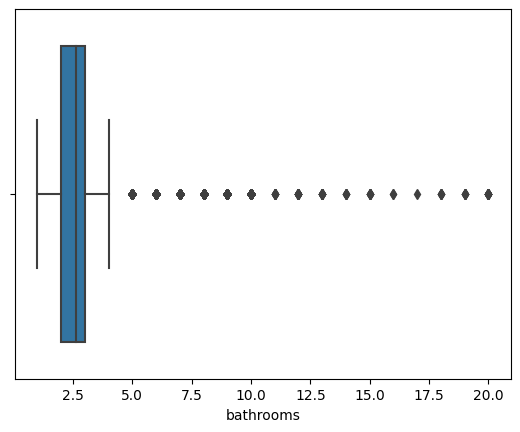

In [43]:
sns.boxplot(x = 'bathrooms', data = data)
plt.show()

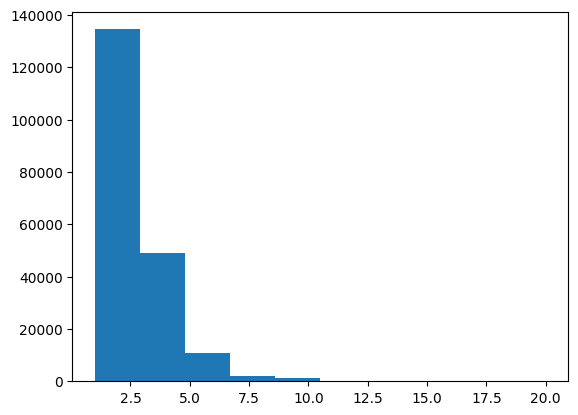

In [44]:
plt.hist(data['bathrooms']) 
plt.show()

In [45]:
# Eliminamos outliers simplificando el modelo, tomando como cantidad máxima 10 baños.
# todas las propiedades que tuvieran más de 10 baños, le imputo 10 baños.
# son 6 veces sigma

In [46]:
def outliers_bathrooms (data):
    data.loc[data[data['bathrooms']>=10].index,'bathrooms']=10
    return data

In [47]:
data = outliers_bathrooms(data)

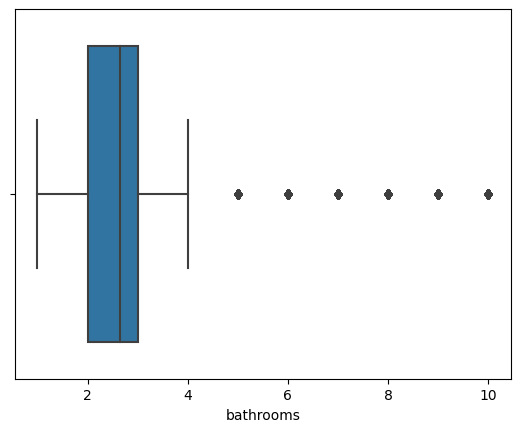

In [48]:
sns.boxplot(x = 'bathrooms', data = data)
plt.show()

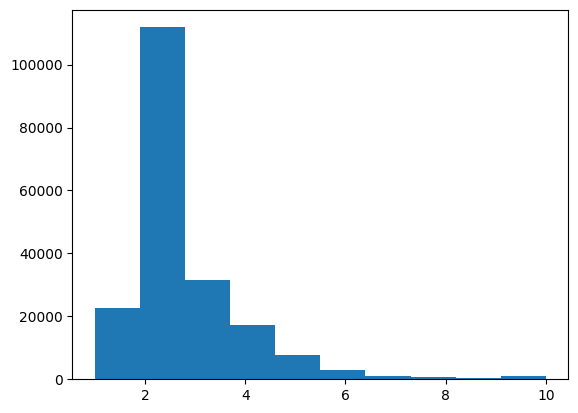

In [49]:
plt.hist(data['bathrooms']) 
plt.show()

In [50]:
# columna property_type
data['property_type'].value_counts()

Apartamento        100495
Casa                60488
Otro                16526
Lote                16501
Local comercial      1252
Finca                1134
Oficina              1080
Parqueadero            10
Name: property_type, dtype: int64

In [51]:
# Podríamos considerar como outlier al valor Parqueadero, que son sólo 10 registros.
# Para no agregar posteriormente una variable dummy adicional, vamos a imputar a esos registros el valor 'Otro'

In [52]:
def outlier_property_type (data):
    data.loc[data[data['property_type']=='Parqueadero'].index,['property_type']]='Otro'
    return data

In [53]:
data = outlier_property_type (data)

In [54]:
data['property_type'].value_counts()

Apartamento        100495
Casa                60488
Otro                16536
Lote                16501
Local comercial      1252
Finca                1134
Oficina              1080
Name: property_type, dtype: int64

In [55]:
# incorporo una columna al modelo para intentar utilizar algo de info de la columna description.
# agregamos una columna que indique la cantidad de palabras que describen la propiedad, a ver si 
# avisos más descriptivos, con mas detalle aportan información sobre el precio de la propiedad.

def col_desc_total_words (data):    
    data['desc_tot_words']=data['description'].apply(lambda x: str(x).count(' '))
    return data

In [56]:
data = col_desc_total_words (data)

In [57]:
data['desc_tot_words'].describe()

count    197486.000000
mean         61.536013
std          45.288997
min           0.000000
25%          34.000000
50%          53.000000
75%          76.000000
max        1383.000000
Name: desc_tot_words, dtype: float64

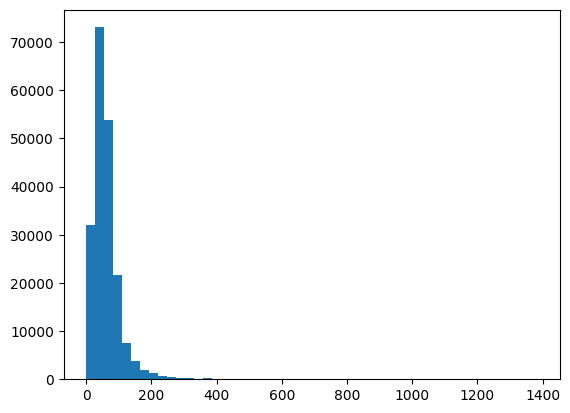

In [58]:
plt.hist(data['desc_tot_words'], bins =50) 
plt.show()

In [59]:
# trunco en 400 palabras

def truncar_cant_words(x):
    if x < 400:
        return x
    else:
        return 300


In [60]:
data['desc_tot_words']=data['desc_tot_words'].apply(truncar_cant_words)

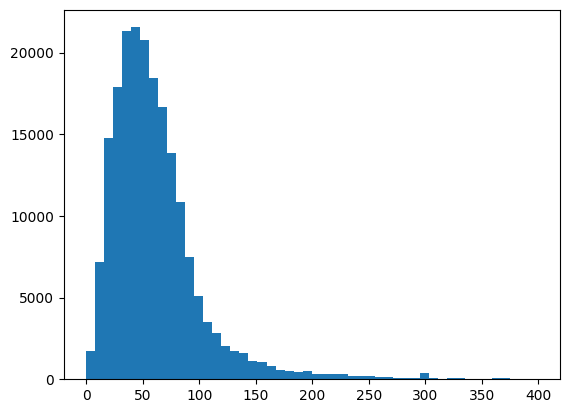

In [61]:
plt.hist(data['desc_tot_words'], bins =50) 
plt.show()

In [62]:
#agrego la columna 'target' con de acuerdo a la consigna.

def caro_barato(x):
    if x > media_precio_orig:
        return 1
    else:
        return 0

data['caro'] = data['price'].apply(lambda x: caro_barato(x))

In [63]:
data['caro'].describe()

count    197486.000000
mean          0.234741
std           0.423838
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: caro, dtype: float64

## Selección Features 1

In [64]:
#    # Quito columnas que no formarán parte del modelo
#
#   COLUMNA                 |       MOTIVO
# --------------------------+-----------------------------------------------------------
#   Unnamed: 0              |       (no agrega información para predecir, es un indice)              
#   id                      |       (no agrega información para predecir, es un indice)
#   ad_type                 |       (no aporta informacion, todo el mismo valor)
#   start_date              |       (no agrega información para predecir, es una fecha)
#   end_date                |       (no agrega información para predecir, es una fecha)
#   created_on              |       (no agrega información para predecir, es una fecha)
#   lat                     |       SE CONSIDERA
#   lon                     |       SE CONSIDERA
#   l1                      |       (info contenida en lat y long, ademas es monovalor)
#   l2                      |       (info contenida en lat y long)
#   l3                      |       (info contenida en lat y long)
#   l4                      |       (info contenida en lat y long)
#   l5                      |       (info contenida en lat y long)
#   l6                      |       (info contenida en lat y long)
#   rooms                   |       (descartar, muchos nulos) 
#   bedrooms                |       (descartar, muchos nulos)
#   bathrooms               |       SE CONSIDERA
#   surface_total           |       (descartar, muchos nulos)
#   surface_covered         |       (descartar, muchos nulos)
#   price                   |       (De acá se genera la variable target)
#   currency                |       (no aporta informacion, todo el mismo valor)
#   price_period            |       (muchos nulos, y monovalor que no tiene sentido al ser una operacion de venta)
#   title                   |       (por ahora no extraemos info de la misma)
#   description             |       (no se considera directamente, se representa con la info extraida en col desc_tot_words)
#   property_type           |       SE CONSIDERA
#   operation_type          |       (no aporta informacion, todo el mismo valor)
#   geometry                |       (info contenida en lat y long)
#   desc_tot_words          |       SE CONSIDERA
#   caro                    |       VAR target s/consigna (1 = caro / 0 = barato)        

# reservo a \data\, para avanzar con la incorporación de otras columnas al modelo quizás más adelante.
# avanzo con \data_model\ para evaluar las variables y comenzar a armar modelos

columnas = ['lat', 'lon', 'bathrooms', 'property_type',
 'desc_tot_words', 'price', 'caro']
data_model=pd.DataFrame()
data_model=data[columnas]    


In [65]:

data_model.head()

,lat,lon,bathrooms,property_type,desc_tot_words,price,caro
0,6.203000,-75.572000,4.0,Casa,168,9.000000e+09,1
1,4.722748,-74.073115,2.0,Apartamento,72,6.250000e+08,0
2,4.709000,-74.030000,2.0,Casa,72,4.200000e+08,0
3,7.117263,-73.115667,1.0,Otro,100,1.310000e+09,1
4,6.244338,-75.573553,2.0,Apartamento,57,2.100000e+08,0


In [66]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197486 entries, 0 to 197485
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   lat             197486 non-null  float64
 1   lon             197486 non-null  float64
 2   bathrooms       197486 non-null  float64
 3   property_type   197486 non-null  object 
 4   desc_tot_words  197486 non-null  int64  
 5   price           197486 non-null  float64
 6   caro            197486 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 10.5+ MB


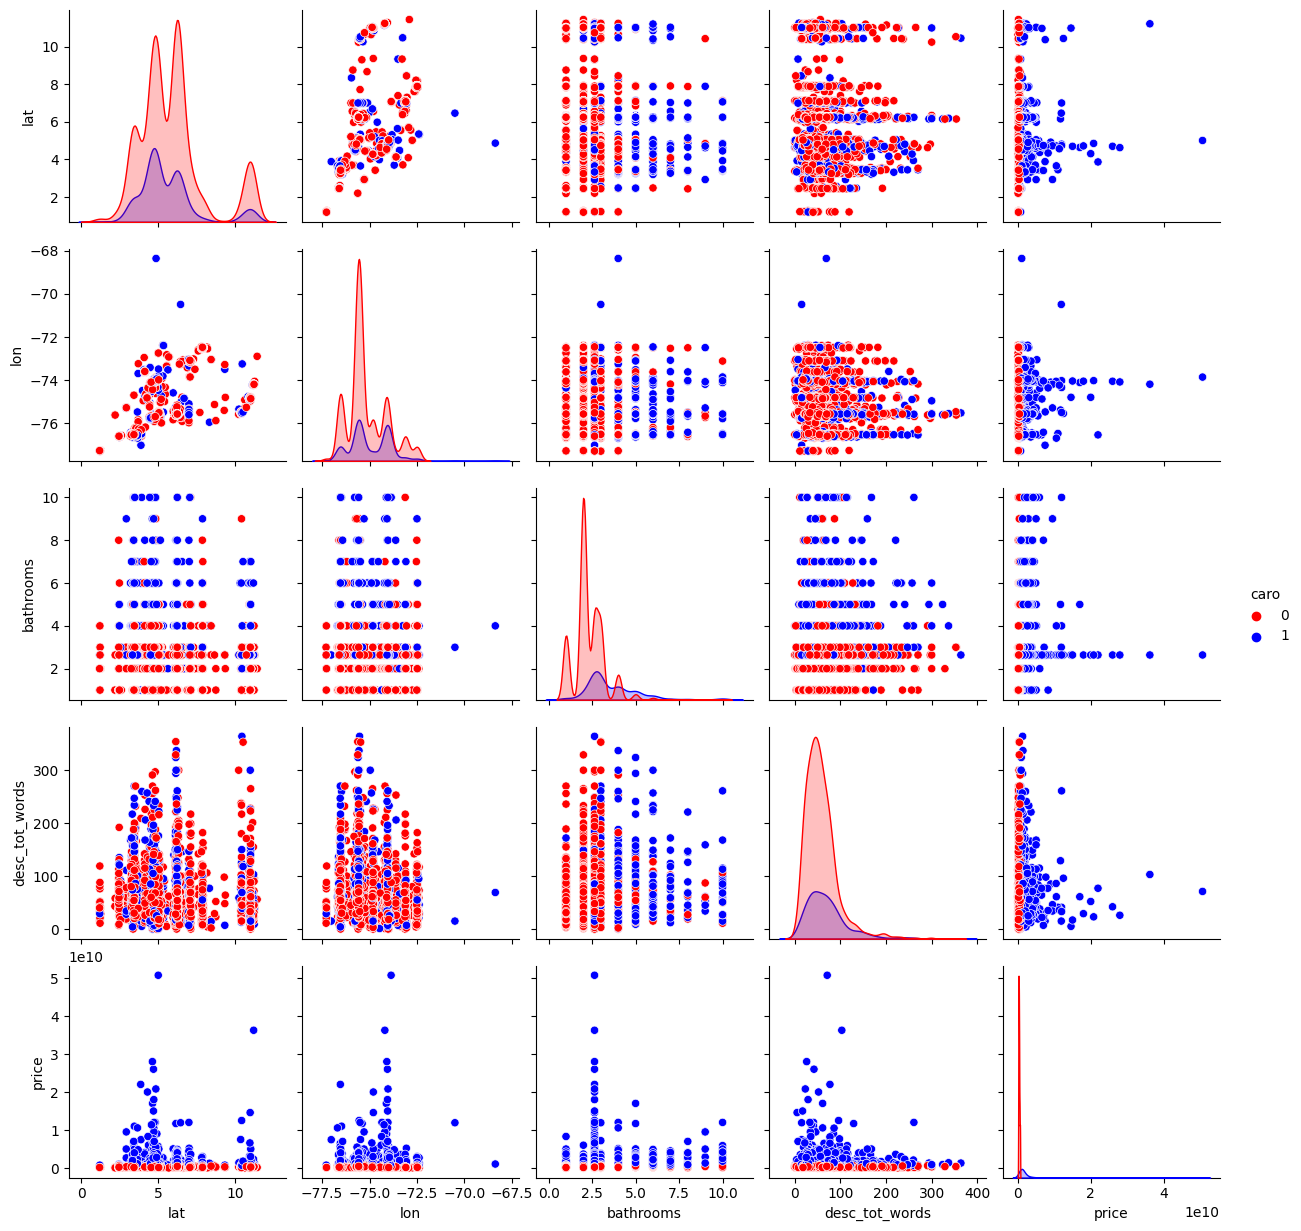

In [67]:
sns.pairplot(data_model.sample(5000), hue="caro", palette = ['r', 'b'])
plt.show()

## Escalado / Normalización

In [68]:
from sklearn.preprocessing import StandardScaler

In [69]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro
count,197486.000000,197486.000000,197486.000000,197486.000000,1.974860e+05,197486.000000
mean,5.819974,-75.113818,2.637229,61.192105,6.436051e+08,0.234741
std,2.085907,1.025720,1.262198,42.246073,1.944868e+09,0.423838
min,-4.212921,-81.728390,1.000000,0.000000,0.000000e+00,0.000000
25%,4.648000,-75.596795,2.000000,34.000000,2.000000e+08,0.000000
50%,5.075436,-75.525502,2.639279,53.000000,3.300000e+08,0.000000
75%,6.244338,-74.150000,3.000000,76.000000,6.000000e+08,0.000000
max,13.351917,-67.482570,10.000000,399.000000,3.450000e+11,1.000000


In [70]:
data_model.describe()
scaler_lat = StandardScaler()
scaler_lon = StandardScaler()
scaler_bath = StandardScaler()
scaler_desc_words = StandardScaler()


scaler_lat.fit(data_model[['lat']])
scaler_lon.fit(data_model[['lon']])
scaler_bath.fit(data_model[['bathrooms']])
scaler_desc_words.fit(data_model[['desc_tot_words']])


data_model['lat'] = scaler_lat.transform(data_model[['lat']])
data_model['lon'] = scaler_lon.transform(data_model[['lon']])
data_model['bathrooms'] = scaler_bath.transform(data_model[['bathrooms']])
data_model['desc_tot_words'] = scaler_desc_words.transform(data_model[['desc_tot_words']])


C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\737995848.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lat'] = scaler_lat.transform(data_model[['lat']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\737995848.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lon'] = scaler_lon.transform(data_model[['lon']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\737995848.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [71]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro
count,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,197486.000000
mean,1.707942e-16,-3.294238e-15,8.829344e-17,-1.487748e-17,6.436051e+08,0.234741
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.944868e+09,0.423838
min,-4.809861e+00,-6.448730e+00,-1.297129e+00,-1.448472e+00,0.000000e+00,0.000000
25%,-5.618548e-01,-4.708680e-01,-5.048581e-01,-6.436616e-01,2.000000e+08,0.000000
50%,-3.569381e-01,-4.013624e-01,1.623469e-03,-1.939145e-01,3.300000e+08,0.000000
75%,2.034442e-01,9.396527e-01,2.874124e-01,3.505162e-01,6.000000e+08,0.000000
max,3.610882e+00,7.439916e+00,5.833307e+00,7.996217e+00,3.450000e+11,1.000000


## Codificación de Variables CAT

In [72]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197486 entries, 0 to 197485
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   lat             197486 non-null  float64
 1   lon             197486 non-null  float64
 2   bathrooms       197486 non-null  float64
 3   property_type   197486 non-null  object 
 4   desc_tot_words  197486 non-null  float64
 5   price           197486 non-null  float64
 6   caro            197486 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.5+ MB


In [73]:
cols_ohe=list(data_model['property_type'].value_counts().index)
def onehot_property_type(data_model, cols_ohe):
    ''' cols_ohe tienen que ser la lista de columnas columnas del dataframe original, asi codifica igual en otro subset'''
    
    # agrego las columnas todas en 0
    data_model[cols_ohe]=0 

    # pongo un 1 en las posiciones que coincida el valor del registro property_type con el nombre de la col en cuestion
    for columna in cols_ohe:    
        data_model.loc[data_model[data_model['property_type']==columna].index,[columna]]=1
    return data_model



In [74]:
data_model = onehot_property_type(data_model, cols_ohe)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [75]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro,Apartamento,Casa,Otro,Lote,Local comercial,Finca,Oficina
count,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,197486.000000,197486.000000,197486.000000,197486.000000,197486.000000,197486.00000,197486.000000,197486.000000
mean,1.707942e-16,-3.294238e-15,8.829344e-17,-1.487748e-17,6.436051e+08,0.234741,0.508872,0.306290,0.083733,0.083555,0.00634,0.005742,0.005469
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.944868e+09,0.423838,0.499923,0.460953,0.276987,0.276720,0.07937,0.075559,0.073749
min,-4.809861e+00,-6.448730e+00,-1.297129e+00,-1.448472e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,-5.618548e-01,-4.708680e-01,-5.048581e-01,-6.436616e-01,2.000000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,-3.569381e-01,-4.013624e-01,1.623469e-03,-1.939145e-01,3.300000e+08,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,2.034442e-01,9.396527e-01,2.874124e-01,3.505162e-01,6.000000e+08,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,3.610882e+00,7.439916e+00,5.833307e+00,7.996217e+00,3.450000e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [76]:
data_model.describe()

,lat,lon,bathrooms,desc_tot_words,price,caro,Apartamento,Casa,Otro,Lote,Local comercial,Finca,Oficina
count,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,1.974860e+05,197486.000000,197486.000000,197486.000000,197486.000000,197486.000000,197486.00000,197486.000000,197486.000000
mean,1.707942e-16,-3.294238e-15,8.829344e-17,-1.487748e-17,6.436051e+08,0.234741,0.508872,0.306290,0.083733,0.083555,0.00634,0.005742,0.005469
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.944868e+09,0.423838,0.499923,0.460953,0.276987,0.276720,0.07937,0.075559,0.073749
min,-4.809861e+00,-6.448730e+00,-1.297129e+00,-1.448472e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,-5.618548e-01,-4.708680e-01,-5.048581e-01,-6.436616e-01,2.000000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,-3.569381e-01,-4.013624e-01,1.623469e-03,-1.939145e-01,3.300000e+08,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,2.034442e-01,9.396527e-01,2.874124e-01,3.505162e-01,6.000000e+08,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,3.610882e+00,7.439916e+00,5.833307e+00,7.996217e+00,3.450000e+11,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [77]:
# from sklearn.preprocessing import OneHotEncoder

In [78]:
#data_encoded = data_model[['property_type']]
#ohe = OneHotEncoder(handle_unknown = 'ignore')
#data_encoded = pd.DataFrame(ohe.fit_transform(data_encoded).toarray())
#data_model = data_model.join(data_encoded)

In [79]:
data_model.isnull().sum()

lat                0
lon                0
bathrooms          0
property_type      0
desc_tot_words     0
price              0
caro               0
Apartamento        0
Casa               0
Otro               0
Lote               0
Local comercial    0
Finca              0
Oficina            0
dtype: int64

In [80]:
data_model.to_csv('df_train.csv')

## -----------------------------------------------------------------------

## Pasos a aplicar a dataset test antes de hacer predict

In [81]:
#abro la data del test
data_test = pd.read_csv('../properties_colombia_test.csv')


In [82]:
# hago las mismas transoformaciones, rellenado de nulos, etc. (excepto la quita de valores)

def transform_test(data):
    data = llenar_latitud(data)
    data = llenar_longitud(data)
    data = llenar_bathrooms (data)
    data = outliers_bathrooms(data)
    data = outlier_property_type(data)
    data = col_desc_total_words(data)
    data['desc_tot_words']=data['desc_tot_words'].apply(truncar_cant_words)
    
    return data



data_test = transform_test(data_test)

# Demora aprox 5 min, 30 seg

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3601405961.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3601405961.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dist'][i]=geodesic(a,b).kilometers


In [83]:
data_test.isnull().sum()

Unnamed: 0             0
id                     0
ad_type                0
start_date             0
end_date               0
created_on             0
lat                    0
lon                    0
l1                     0
l2                     0
l3                     0
l4                 50776
l5                 56798
l6                 63486
rooms              56740
bedrooms           52447
bathrooms              0
surface_total      63536
surface_covered    62545
currency              17
price_period       53729
title                  0
description           27
property_type          0
operation_type         0
geometry               0
desc_tot_words         0
dtype: int64

In [84]:
# replico el uso de las columnas que componen el modelo para este subset

data_model_test = pd.DataFrame()
columnas_test = columnas = ['lat', 'lon', 'bathrooms', 'property_type','desc_tot_words']
data_model_test = data_test[columnas]

In [85]:
data_model_test.describe()

,lat,lon,bathrooms,desc_tot_words
count,65850.000000,65850.000000,65850.000000,65850.000000
mean,5.833646,-75.115216,2.638197,60.716234
std,2.100318,1.024412,1.255925,41.630425
min,-4.212921,-81.705052,1.000000,0.000000
25%,4.649456,-75.596142,2.000000,34.000000
50%,5.077178,-75.525287,2.639624,53.000000
75%,6.244338,-74.150851,3.000000,75.000000
max,13.338761,-67.924336,10.000000,399.000000


In [86]:
#replico el escalado de las variables del modelo

def scale_test(data_model):
    data_model['lat'] = scaler_lat.transform(data_model[['lat']])
    data_model['lon'] = scaler_lon.transform(data_model[['lon']])
    data_model['bathrooms'] = scaler_bath.transform(data_model[['bathrooms']])
    data_model['desc_tot_words'] = scaler_desc_words.transform(data_model[['desc_tot_words']])
    return data_model
data_model_test = scale_test(data_model_test)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3662038155.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lat'] = scaler_lat.transform(data_model[['lat']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3662038155.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model['lon'] = scaler_lon.transform(data_model[['lon']])
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3662038155.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [87]:
data_model_test.describe()

,lat,lon,bathrooms,desc_tot_words
count,65850.000000,65850.000000,65850.000000,65850.000000
mean,0.006555,-0.001363,0.000766,-0.011264
std,1.006911,0.998728,0.995033,0.985430
min,-4.809861,-6.425977,-1.297129,-1.448472
25%,-0.561157,-0.470232,-0.504858,-0.643662
50%,-0.356103,-0.401153,0.001897,-0.193914
75%,0.203444,0.938823,0.287412,0.326845
max,3.604575,7.009225,5.833307,7.996217


In [88]:
data_model_test['property_type'].value_counts()

Apartamento        33524
Casa               20084
Lote                5704
Otro                5379
Local comercial      434
Finca                377
Oficina              348
Name: property_type, dtype: int64

In [89]:
# replico la codificacion onehot usada previamente
data_model_test = onehot_property_type(data_model_test, cols_ohe)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model[cols_ohe]=0
C:\Users\FedeGP\AppData\Local\Temp\ipykernel_20628\3384754271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [90]:
# Datos listos para pasar hacer predict
data_model_test.describe()

,lat,lon,bathrooms,desc_tot_words,Apartamento,Casa,Otro,Lote,Local comercial,Finca,Oficina
count,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000,65850.000000
mean,0.006555,-0.001363,0.000766,-0.011264,0.509096,0.304996,0.081686,0.086621,0.006591,0.005725,0.005285
std,1.006911,0.998728,0.995033,0.985430,0.499921,0.460409,0.273887,0.281281,0.080916,0.075448,0.072504
min,-4.809861,-6.425977,-1.297129,-1.448472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.561157,-0.470232,-0.504858,-0.643662,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.356103,-0.401153,0.001897,-0.193914,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.203444,0.938823,0.287412,0.326845,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.604575,7.009225,5.833307,7.996217,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [91]:
data_model_test.to_csv('df_test.csv')

## ---------------------------------------------------------------

## MODELOS

In [3]:
# se pueden importar los csvs ya preparados (df_test.csv y df_train.csv) y arrancar desde acá en un nuevo notebook
data_model_test = pd.read_csv('df_test.csv')
data_model = pd.read_csv('df_train.csv')

In [6]:
columnas_x = ['lat', 'lon', 'bathrooms', 'desc_tot_words', 'Apartamento', 'Casa', 'Otro', 'Lote', 'Local comercial', 'Finca', 'Oficina']
columna_y = ['caro']

X = np.array(data_model.loc[:,columnas_x])
y = np.array(data_model.loc[:,columna_y])
X_testigo_entrega = np.array(data_model_test.loc[:,columnas_x])

from sklearn.model_selection import train_test_split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size = 0.25, random_state=0, stratify=y)

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

### 1. Arbol simple

In [7]:
from sklearn.tree import DecisionTreeClassifier


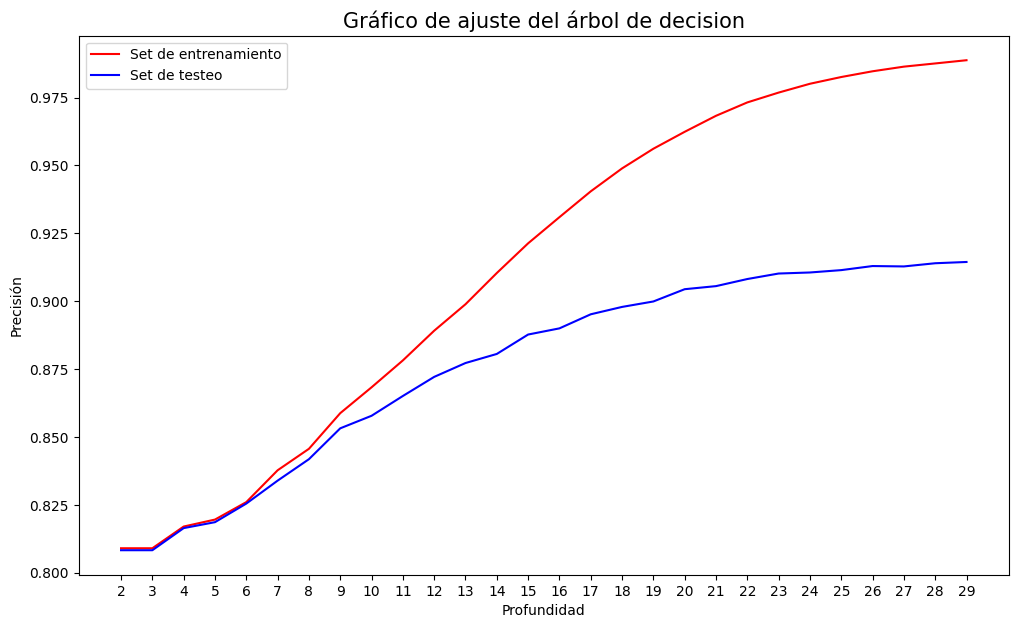

In [8]:
train_prec =  []
eval_prec = []
max_deep_list = list(range(2, 30))

for deep in max_deep_list:
    clf_3 = DecisionTreeClassifier(max_depth=deep, criterion='entropy')
    clf_3.fit(X_Train, Y_Train)
    train_prec.append(clf_3.score(X_Train, Y_Train))
    eval_prec.append(clf_3.score(X_Test, Y_Test))


plt.figure(figsize=(12,7))
plt.plot(max_deep_list, train_prec, color='r', label='Set de entrenamiento')
plt.plot(max_deep_list, eval_prec, color='b', label='Set de testeo')
plt.title('Gráfico de ajuste del árbol de decision', fontsize = 15)
plt.legend()
plt.xticks([i for i in max_deep_list])
plt.ylabel('Precisión')
plt.xlabel('Profundidad')
plt.show()

In [9]:
# observamos que el óptimo se logra en profundidad 9
clf_3 = DecisionTreeClassifier(max_depth=9, criterion='entropy')
clf_3.fit(X_Train, Y_Train)
y_pred = clf_3.predict(X_Test)
print('Accuracy: ', accuracy_score(Y_Test,y_pred))
print('Recall: ', recall_score(Y_Test,y_pred))
print('Feature importance: ', clf_3.feature_importances_)


Accuracy:  0.8532366523535607
Recall:  0.6472821397756687
Feature importance:  [0.13614279 0.11638887 0.56208194 0.03979423 0.04599894 0.02963538
 0.05961219 0.00899899 0.         0.00070771 0.00063896]


In [117]:
entrega_pred = clf_3.predict(X_testigo_entrega)
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
# esta es la entrega n°1 (se usó depth = 30, muy overfitteado)

## 2. K-Vecinos

In [141]:
from sklearn.neighbors import KNeighborsClassifier

# Instanciamos un objeto de la clase KNeighborsClassifier

clf1 = KNeighborsClassifier(n_neighbors = 5)
clf1.fit(X_Train,Y_Train)
y_pred = clf1.predict(X_Test)

print('Accuracy: ', accuracy_score(Y_Test,y_pred), '\t', 'Recall: ', recall_score(Y_Test,y_pred))



c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy:  0.8754152151016771 	 Recall:  0.7047210300429184


In [138]:
accur_train=[]
accur_test=[]
recall=[]
vecinos = list(range(2, 15))

for i in vecinos:
    clf1 = KNeighborsClassifier(n_neighbors = i)
    clf1.fit(X_Train,Y_Train)
    y_pred = clf1.predict(X_Test)
    y_pred_train = clf1.predict(X_Train)
    accur_train.append(accuracy_score(Y_Train,y_pred_train))
    accur_test.append(accuracy_score(Y_Test,y_pred))
    recall.append(recall_score(Y_Test,y_pred))


c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:2

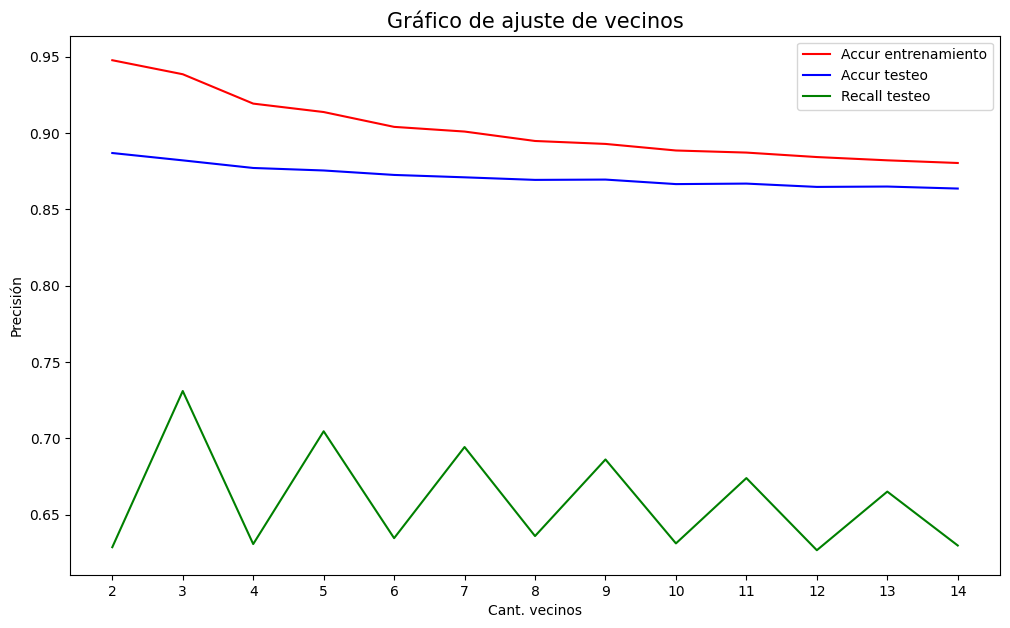

In [139]:
plt.figure(figsize=(12,7))
plt.plot(vecinos, accur_train, color='r', label='Accur entrenamiento')
plt.plot(vecinos, accur_test, color='b', label='Accur testeo')
plt.plot(vecinos, recall, color='g', label='Recall testeo')
plt.title('Gráfico de ajuste de vecinos', fontsize = 15)
plt.legend()
plt.xticks([i for i in vecinos])
plt.ylabel('Precisión')
plt.xlabel('Cant. vecinos')
plt.show()

In [140]:
# Vemos que el óptimo se encuentra en 3
clf1 = KNeighborsClassifier(n_neighbors = 3)
clf1.fit(X_Train,Y_Train)
y_pred = clf1.predict(X_Test)
y_pred_train = clf1.predict(X_Train)
print('Accuracy:', accuracy_score(Y_Test,y_pred))
print('Recall:', recall_score(Y_Test,y_pred))

c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.8820384023333063
Recall: 0.7310729613733905


In [142]:
entrega_pred = clf1.predict(X_testigo_entrega)
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
#entrega 2

## 3. Regresion Logistica

In [143]:
from sklearn.linear_model import LogisticRegression

# Instanciamos el modelo y lo entrenamos

clf = LogisticRegression()

# Lo entrenamos

clf.fit(X_Train,Y_Train)

c:\Users\FedeGP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [145]:
y_pred = clf.predict(X_Test)
y_pred_train = clf.predict(X_Train)
print('Accuracy_Train:', accuracy_score(Y_Train,y_pred_train))
print('Accuracy_Test:', accuracy_score(Y_Test,y_pred))
print('Recall:', recall_score(Y_Test,y_pred))

## 4. ARBOL c/ CROSS VALIDATION Y WEIGHT DECISION

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [58]:
tree = DecisionTreeClassifier()
tree_scores = cross_validate(tree, X, y, cv=5, scoring = 'f1')

In [59]:
print(tree_scores)

{'fit_time': array([0.68365955, 0.69557953, 0.7006197 , 0.67803574, 0.65613818]), 'score_time': array([0.01900101, 0.02005124, 0.01900125, 0.01999974, 0.01906252]), 'test_score': array([0.82398788, 0.81849837, 0.82857452, 0.82009549, 0.82363106])}


In [15]:
from sklearn.model_selection import GridSearchCV

In [22]:
weights = {0:1, 1:2}
clf5 = DecisionTreeClassifier(max_depth=9, class_weight=weights)
clf5.fit(X_Train, Y_Train)
y_pred = clf5.predict(X_Test)
print('Recall: ', recall_score(Y_Test,y_pred))
print('Accuracy: ', accuracy_score(Y_Test,y_pred))
print('Feature importance: ', clf5.feature_importances_)

Recall:  0.7916307161345988
Accuracy:  0.835554565340679
Feature importance:  [1.07567193e-01 1.13731017e-01 6.12584733e-01 3.18154640e-02
 4.38610910e-02 3.07203873e-02 4.83539454e-02 1.05027824e-02
 0.00000000e+00 5.30489329e-04 3.32897934e-04]


In [49]:
clf6 = DecisionTreeClassifier()
balance = [{0:1,1:1}, {0:1,1:3}, {0:1,1:10}, {0:1,1:50}, {0:1,1:100}]
depths = list(range(3,30))
param_grid = dict(class_weight = balance, max_depth = depths)
model = GridSearchCV(clf6, param_grid=param_grid, cv=5, scoring ='f1')

In [51]:
model.fit(X_Train, Y_Train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 3},
                                          {0: 1, 1: 10}, {0: 1, 1: 50},
                                          {0: 1, 1: 100}],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                       15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                       25, 26, 27, 28, 29]},
             scoring='f1')

In [52]:
print("Mejores hiperparámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

scores = pd.DataFrame(model.cv_results_)
scores

Mejores hiperparámetros: {'class_weight': {0: 1, 1: 3}, 'max_depth': 29}
Mejor Score: 0.7986876991469022



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.174209,0.003288,0.012123,0.001021,"{0: 1, 1: 1}",3,"{'class_weight': {0: 1, 1: 1}, 'max_depth': 3}",0.549602,0.559772,0.554614,0.550307,0.564245,0.555708,0.005604,118
1,0.209239,0.010083,0.011421,0.000788,"{0: 1, 1: 1}",4,"{'class_weight': {0: 1, 1: 1}, 'max_depth': 4}",0.547835,0.536891,0.532375,0.544985,0.541812,0.540780,0.005555,119
2,0.237208,0.002546,0.010521,0.000512,"{0: 1, 1: 1}",5,"{'class_weight': {0: 1, 1: 1}, 'max_depth': 5}",0.553607,0.568838,0.568944,0.548993,0.575826,0.563242,0.010179,113
3,0.271897,0.003873,0.011000,0.000891,"{0: 1, 1: 1}",6,"{'class_weight': {0: 1, 1: 1}, 'max_depth': 6}",0.561086,0.557215,0.550344,0.555795,0.571892,0.559266,0.007192,115
4,0.303840,0.006225,0.011828,0.000418,"{0: 1, 1: 1}",7,"{'class_weight': {0: 1, 1: 1}, 'max_depth': 7}",0.606180,0.622509,0.618218,0.614051,0.621438,0.616479,0.005932,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.513864,0.010734,0.016409,0.000541,"{0: 1, 1: 100}",25,"{'class_weight': {0: 1, 1: 100}, 'max_depth': 25}",0.723725,0.723043,0.731648,0.724575,0.732868,0.727172,0.004199,58
131,0.520812,0.008240,0.016658,0.000749,"{0: 1, 1: 100}",26,"{'class_weight': {0: 1, 1: 100}, 'max_depth': 26}",0.730866,0.730576,0.740217,0.734272,0.741677,0.735522,0.004640,53
132,0.528510,0.006950,0.016624,0.000491,"{0: 1, 1: 100}",27,"{'class_weight': {0: 1, 1: 100}, 'max_depth': 27}",0.737245,0.739174,0.747310,0.741298,0.746781,0.742362,0.004037,49
133,0.531155,0.009339,0.016436,0.000762,"{0: 1, 1: 100}",28,"{'class_weight': {0: 1, 1: 100}, 'max_depth': 28}",0.742864,0.746803,0.755026,0.749107,0.755155,0.749791,0.004765,44


In [54]:
y_pred = model.predict(X_Test)
y_pred_train = model.predict(X_Train)
print('Accuracy_Train:', accuracy_score(Y_Train,y_pred_train))
print('Accuracy_Test:', accuracy_score(Y_Test,y_pred))
print('Recall:', recall_score(Y_Test,y_pred))

Accuracy_Train: 0.9867196888882888
Accuracy_Test: 0.9114275297739609
Recall: 0.8287316652286454


In [56]:
param_grid1 #guarde la grid de la primera corrida
best_params1 #guarde los mejores parametros de esa primera corrida

{'class_weight': {0: 1, 1: 3}, 'max_depth': 29}

In [63]:
entrega_pred = model.predict(X_testigo_entrega)
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
#entrega 3 mejores hiperparámetros: {'class_weight': {0: 1, 1: 3}, 'max_depth': 29}

In [64]:
#clf6 = DecisionTreeClassifier()
#balance = [{0:1,1:2}, {0:1,1:3}, {0:1,1:4}, {0:1,1:5}, {0:1,1:6}, {0:1,1:7}, {0:1,1:8}, {0:1,1:9}]
#depths = list(range(6,30))
#param_grid = dict(class_weight = balance, max_depth = depths)
#model = GridSearchCV(clf6, param_grid=param_grid, cv=5, scoring ='f1')
#Se ejecutó esto tambien, y dio otros hiperparam {'class_weight': {0: 1, 1: 2}, 'max_depth': 29}, con result casi identido

## 5. Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

In [69]:
clf = RandomForestClassifier(n_estimators=100, max_features='sqrt', class_weight= {0: 1, 1: 2}, n_jobs=-1, oob_score = True, random_state = 42)
clf.fit(X_Train, Y_Train)

C:\Users\FedeGP\AppData\Local\Temp\ipykernel_16980\4278736472.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_Train, Y_Train)


RandomForestClassifier(class_weight={0: 1, 1: 2}, n_jobs=-1, oob_score=True,
                       random_state=42)

In [72]:
y_pred = clf.predict(X_Test)
y_pred_train = clf.predict(X_Train)
print('Accuracy_Train:', accuracy_score(Y_Train,y_pred_train))
print('Accuracy_Test:', accuracy_score(Y_Test,y_pred))
print('Recall:', recall_score(Y_Test,y_pred))

print('Feature importance: ', clf.feature_importances_)

Accuracy_Train: 0.9917563498386378
Accuracy_Test: 0.9264967998055578
Recall: 0.8264883520276101
Feature importance:  [0.22028964 0.21702547 0.28417576 0.18681936 0.04233208 0.01148618
 0.02512511 0.00716369 0.00158046 0.00291583 0.00108642]


In [71]:
entrega_pred = model.predict(X_testigo_entrega)
entrega_pred_df=pd.DataFrame()
entrega_pred_df['pred']=entrega_pred
entrega_pred_df.to_csv('fedegp1.csv', index=False)
# entrega 4

## 6. Regresion polinomica múltiple 

In [ ]:
# cambio de estrategia.
# En vez de clasificar en 0/1. Vamos a armar un modelo que prediga el precio de la propiedad.
# Luego clasificamos la predicción de precio en 0/1 y evaluamos si mejora el modelo. 